In [56]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder


#modeles :
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score


import time
import pickle


from termcolor import colored
import os
import warnings
warnings.filterwarnings('ignore')

## Chargement des fichiers et du dataframe :

In [57]:
path_encoder_feature = "feature_encoders.pkl"
path_encoder_label = "label_encoders.pkl"

path_scaler = "scaler.pkl"

# path_low_nan = "/kaggle/input/df-preprocessed-poisonous-mushrooms/low_nan_col.pkl"
path_imputer_median = "imputer_mediane.pkl"
path_imputer_mode = "imputer_mode.pkl"

path_df ="df_preprocessed.csv"


In [58]:
def read_data(path):
    with open(path, 'rb') as file:
        loaded_file = pickle.load(file)
        name = path.split('/')[-1]
    print(f"Données chargées depuis {colored(path,'blue')} : {colored(name,'green',attrs=['bold'])}")
    return loaded_file

In [59]:
encoder_feature = read_data(path_encoder_feature)
encoder_label = read_data(path_encoder_label)
scaler =  read_data(path_scaler)
imputer_median = read_data(path_imputer_median)
imputer_mode = read_data(path_imputer_mode)

Données chargées depuis feature_encoders.pkl : feature_encoders.pkl
Données chargées depuis label_encoders.pkl : label_encoders.pkl
Données chargées depuis scaler.pkl : scaler.pkl
Données chargées depuis imputer_mediane.pkl : imputer_mediane.pkl
Données chargées depuis imputer_mode.pkl : imputer_mode.pkl


In [60]:
data = pd.read_csv(path_df,index_col = 0)

In [84]:
df = data.copy()
# df = df.sample(n=1000000, random_state=42)
print(df.shape)
df.head()

(3116945, 17)


,id,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season,class
0,0,0.534797,1,1,1,0,0,0,3,-0.680893,0.523513,2,0,0,0,0,0
1,1,-0.386386,4,0,1,0,0,0,0,-0.577198,-0.577326,1,2,1,0,3,1
2,2,0.135403,1,1,1,0,3,0,3,0.185705,-0.151075,0,0,0,2,3,0
3,3,-0.521664,1,3,1,0,2,0,1,-0.810513,-0.571148,2,0,0,0,2,0
4,4,-0.098651,4,0,2,0,1,0,3,-1.103082,-0.345050,2,0,0,1,0,0


In [85]:
X = df.drop("class",axis=1)
y = df["class"]
X_train,X_test,y_train,y_test = train_test_split(X,y, stratify=y, test_size=0.2, random_state=42)

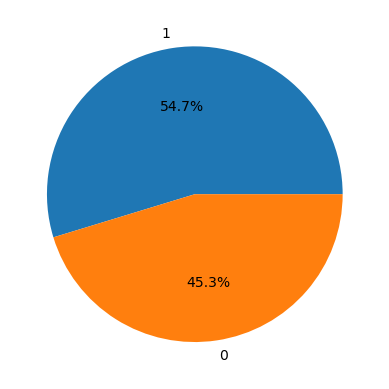

In [86]:
prop_targ = df["class"].value_counts(normalize=True)
plt.pie(prop_targ.values, labels=prop_targ.keys(), autopct='%1.1f%%' )
plt.show()

In [87]:
# Création des fonctions de modélisation :

In [88]:
def train(model):
    """Fonction qui entraine un modèle et affiche le score obtenu sur 5 splits après
    cross validation et le score moyen. 
    Renvoi un tuple de trois éléments :
    (predictions, temps d'execution, le modèle entrainé)"""
    
    scores = cross_val_score(estimator=model, X=X_train.values, y=y_train)
    
    start_time = time.time()
    
    model.fit(X_train,y_train)
    
    end_time = time.time()
    
    # durée totale de l'entrainement 
    training_time = round(end_time - start_time,2)
    
    # Durée en minute :
    training_time_min = round(training_time/60,2)

    yp = model.predict(X_test.values)
    
    print(colored(type(model).__name__,"light_green",attrs=["bold"]))
    print("Scores sur 5 splits : ", [i.round(3) for i in scores])
    print("Score moyen :", scores.mean().round(3))

    return (yp, training_time_min, model)

def metric(prediction, model_name):
    """Fonction qui renvoie un objet pandas Series contenant les valeurs des metrics
    principales : f1 score, accuracy, recall, precision score à partir de la liste des prédictions d'un modèle"""
    
    f1 = metrics.f1_score(y_true = y_test, y_pred = prediction, average='weighted')
    accuracy = metrics.accuracy_score(y_true = y_test, y_pred = prediction)
    recal = metrics.recall_score(y_true = y_test, y_pred = prediction, average='weighted')
    precision = metrics.precision_score(y_true = y_test, y_pred = prediction, average='weighted')
    
    all_metric = [f1,accuracy,recal,precision]
    
    index_metric = ["F1-score","Accuracy","Recall","Precision"]
    
    series = pd.Series(all_metric, name=str(model_name), index=index_metric)
    return pd.DataFrame(series)

def trainig_series(list_models):
    """Fonction qui entraine en série plusieurs modèle à la fois
    Renvoie un tuple contenant 4 éléments :
    DataFrame contenant toutes les métrics
    DataFrame contenant toutes les prédictions de modèles
    Dictionnaire contenant tout les modèles préentrainés
    Dictionnaire contenant le temps d'entrainement de chaque modèle
    """
    #Dictionnaire qui contiendra les différentes metrics de chaque modèle
    dict_metric = {}
    #dictionnaire contenant les valeurs prédictives pour chaque modèles
    dict_prediction = {}
    #dictionnaire contenant les modele entrainé
    dict_model_trained = {}
    #dictionnaire contenant le temps d'exécution 
    dict_time ={}
        
    
    for current_model in list_models:
        #Recuperation des prédictions et du temps d'execution de chaque modèles
        prediction, temps_exe, model_trained = train(current_model)

        # Récupération du nom du modèle et du chemin d'enregistrement
        model_name = type(current_model).__name__

        # Enregitrement des modèles après entrainement : 
        dict_model_trained[model_name] = model_trained

        #Enregistrement des prédiction dans le dictionnaire :
        dict_prediction[model_name] = prediction

        # Enregistrement des métriques au dictionnaire
        dict_metric[model_name] = metric(prediction=prediction, model_name=model_name)
        
        #Enregistrement du tps d'execution
        dict_time[model_name] = temps_exe  
        
    #Pour les Dataframe :    
    # Concaténation des métriques en un DataFrame et inversion des colonnes et index :
    df_metrics = pd.concat(dict_metric.values(), axis=1).T 
    #Enregistrement des prédictions dans un dataframe :
    df_prediction = pd.DataFrame(dict_prediction)
    
    return (df_metrics,df_prediction,dict_model_trained, dict_time)

def enregistrement_model(pretrained_models):
    """Prend en entrée un dictionnaire sous forme {nom_modèle : modèle préentrainé}"""
    for i in pretrained_models:
        model_name = i
        current_model = pretrained_models[model_name]
        model_filename = os.path.join(f"{model_name}.pkl")
        #Enregistrement des modèles préentrainé :
        with open(model_filename, 'wb') as model_file:
            pickle.dump(current_model, model_file)
        print(f'{colored(model_name,"blue")} enregistré sous {colored(model_filename,"green")}')
        
 #visualisation du temp d'entrainement
def graph_time(dictionnary_time):
    """Fonction qui récupère un dictionnaire contenant les informations sur la durée d'entrainement des modèles et renvoie un barplot"""
    df_time = pd.DataFrame.from_dict(dictionnary_time, orient = "index", columns=["Duree d'entrainement"])
    plt.figure(figsize=(16,4))
    plt.grid()
    ax = sns.barplot(x = df_time.index, y = df_time.columns[0], data = df_time)
    ax.set_xticklabels(labels = df_time.index, rotation = 45)
    plt.xlabel("Modèles")
    plt.title("Durée d'entrainement des différents modèles (en minutes)")
    plt.show()

    
#Visualisation des metrics avec un barplot
def metric_plot(df_metric):
    mesure_reset = df_metric.reset_index()
    # Ensuite, ON utilise melt avec le nouvel index comme id_vars
    metric_df_melt = mesure_reset.melt(id_vars="index", var_name="Model", value_name="Score")

    plt.figure(figsize=(16,6))
    plt.grid()
    sns.barplot(data=metric_df_melt, x="index", y="Score", hue="Model")
    plt.legend(bbox_to_anchor=(1,1))
    plt.title('Comparaison des scores des modèles')
    plt.show()
    
def matrice(pred, nrow, ncol):
    plt.figure(figsize=(14, 14))  
    for i, col in enumerate(pred, 1):
        cf = metrics.confusion_matrix(y_true=y_test, y_pred=pred[col])
        ax = plt.subplot(nrow, ncol, i)
        sns.heatmap(cf, annot=True, ax=ax,linewidths=0.8, linecolor="black",fmt=".0f", cbar=False, cmap="Blues")
        ax.set_xlabel('Prédictions')
        ax.set_ylabel('Valeurs réelles')
        ax.set_title(f"{col}")
    plt.tight_layout()  # Pour éviter les chevauchements
    plt.show()

def ROC(model_list, X_test, y_test, nrow, ncol):
    """Fonction pour obtenir la courbe ROC pour plusieurs modèles de classification binaire"""
    plt.figure(figsize=(15, 10))

    # Boucle sur chaque modèle et on trace la courbe ROC dans un sous-graphique
    for i, model in enumerate(model_list):
        plt.subplot(nrow, ncol, i + 1)  # i+1 parce que subplot commence à 1

        # Prédiction des probabilités pour le modèle courant
        predicted_probabilities = model_list[model].predict(X_test)

        # Calcul de la courbe ROC et de l'AUC
        fpr, tpr, _ = roc_curve(y_test, predicted_probabilities)
        roc_auc = auc(fpr, tpr)

        # Tracé de la courbe ROC
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
        
        # Ligne en pointillés représentant la performance aléatoire
        plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Aléatoire')
        
        # Ajout des légendes et des titres
        plt.legend(loc="lower right")
        plt.xlabel('Taux de faux positifs (FPR)')
        plt.ylabel('Taux de vrais positifs (TPR)')
        plt.title(f'Courbe ROC - {model}')
        plt.grid()

    plt.tight_layout()  
    plt.show()       

In [90]:
##### Liste des modèles utilisés :
all_model = [
    DummyClassifier(strategy="most_frequent"),
    LogisticRegression(),
#     KNeighborsClassifier(),
#     SGDClassifier(loss="modified_huber"), 
     RandomForestClassifier(),
     AdaBoostClassifier(),
    XGBClassifier()
            ]

#Remarque : loss = "modified_huber" SGDC,cela permet d'utiliser le "predict_proba(X_test.values)"
# c'est indispensable à notre fonction ROC (car on utilise predict_proba et label_binarizer)
#sinon cela ne fonctionne pas car la courbe ROC n'est pas adapté aux problèmes non binaires

In [92]:
#Entrainement en série :
mesure, prediction,model_entraine, exe_time = trainig_series(all_model)

DummyClassifier
Scores sur 5 splits :  [0.547, 0.547, 0.547, 0.547, 0.547]
Score moyen : 0.547
LogisticRegression
Scores sur 5 splits :  [0.547, 0.547, 0.547, 0.547, 0.547]
Score moyen : 0.547
RandomForestClassifier
Scores sur 5 splits :  [0.989, 0.989, 0.989, 0.989, 0.989]
Score moyen : 0.989
AdaBoostClassifier
Scores sur 5 splits :  [0.75, 0.746, 0.747, 0.743, 0.746]
Score moyen : 0.747
XGBClassifier
Scores sur 5 splits :  [0.987, 0.987, 0.987, 0.987, 0.987]
Score moyen : 0.987


In [95]:
#Sauvegarde des modèles préentrainé :
enregistrement_model(model_entraine)

DummyClassifier enregistré sous DummyClassifier.pkl
LogisticRegression enregistré sous LogisticRegression.pkl
RandomForestClassifier enregistré sous RandomForestClassifier.pkl
AdaBoostClassifier enregistré sous AdaBoostClassifier.pkl
XGBClassifier enregistré sous XGBClassifier.pkl


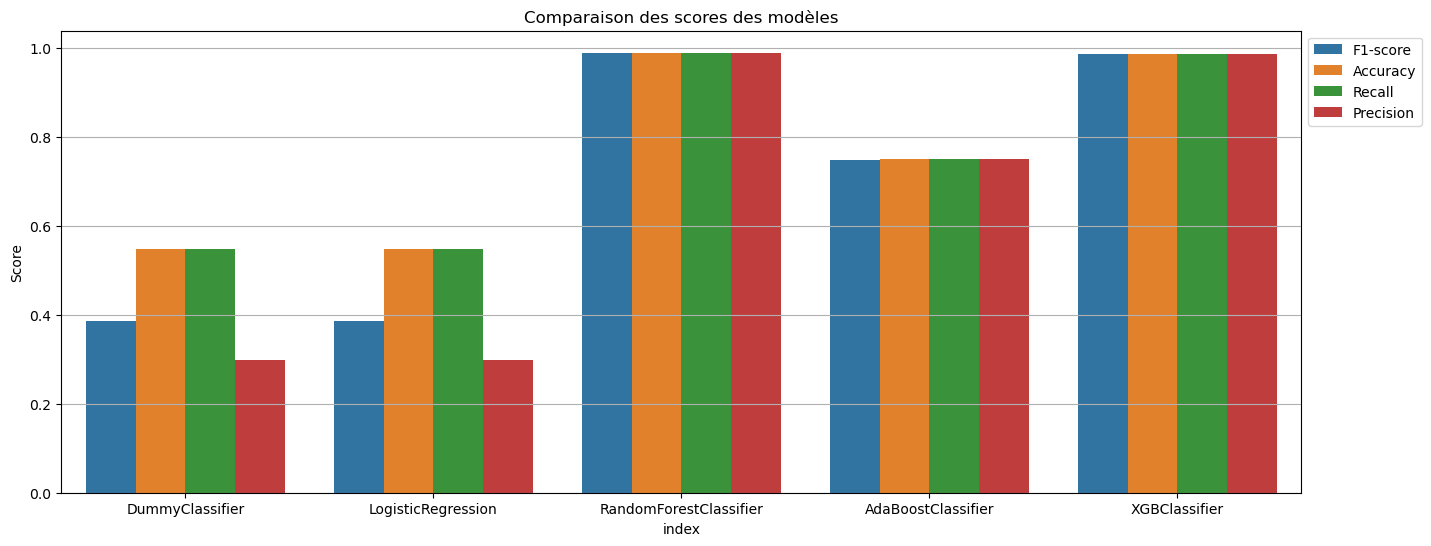

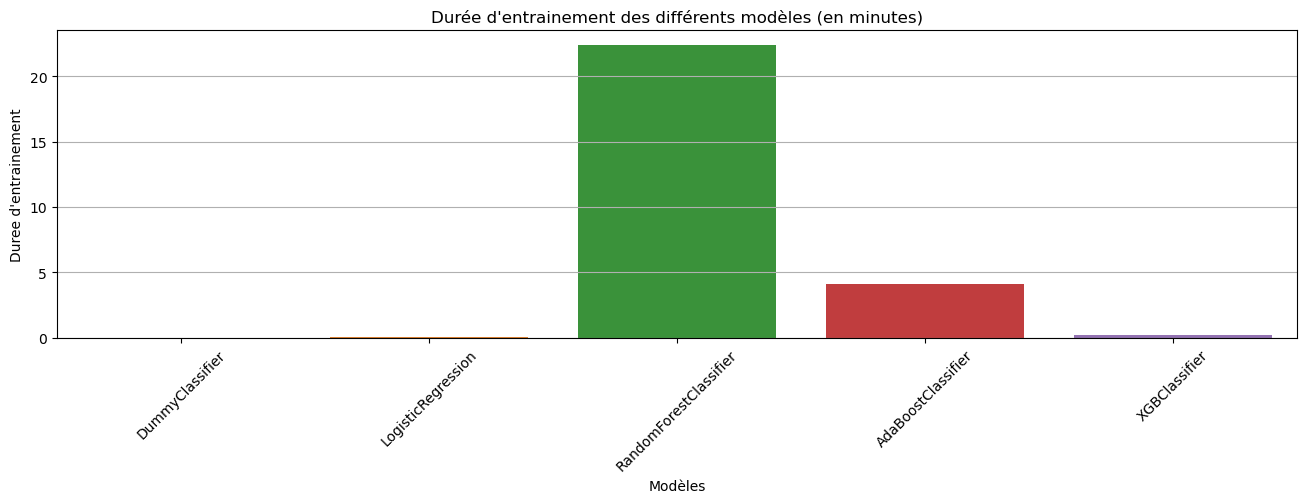

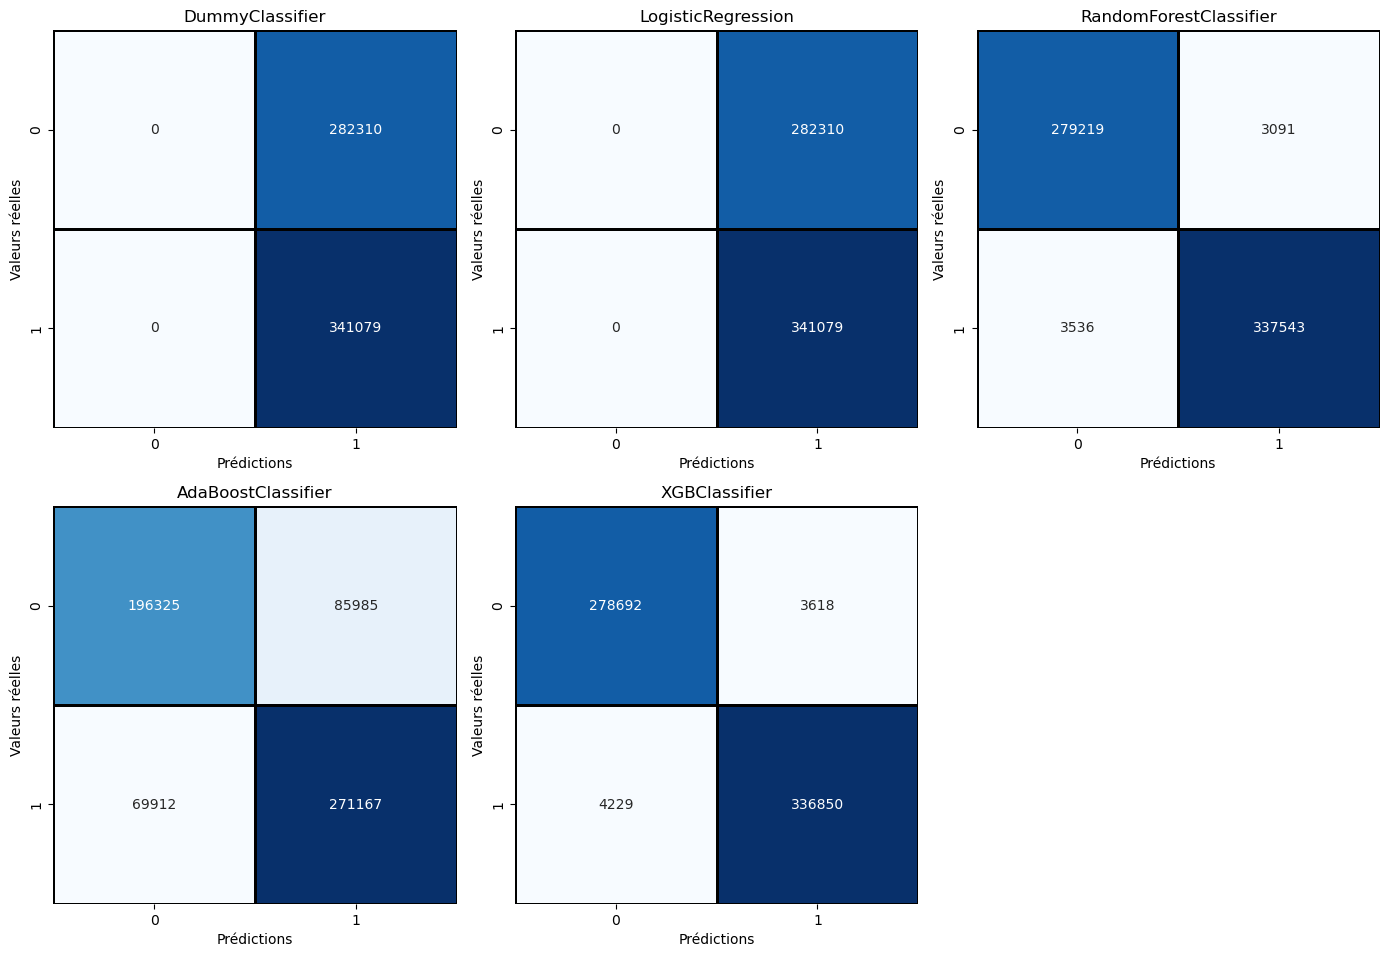

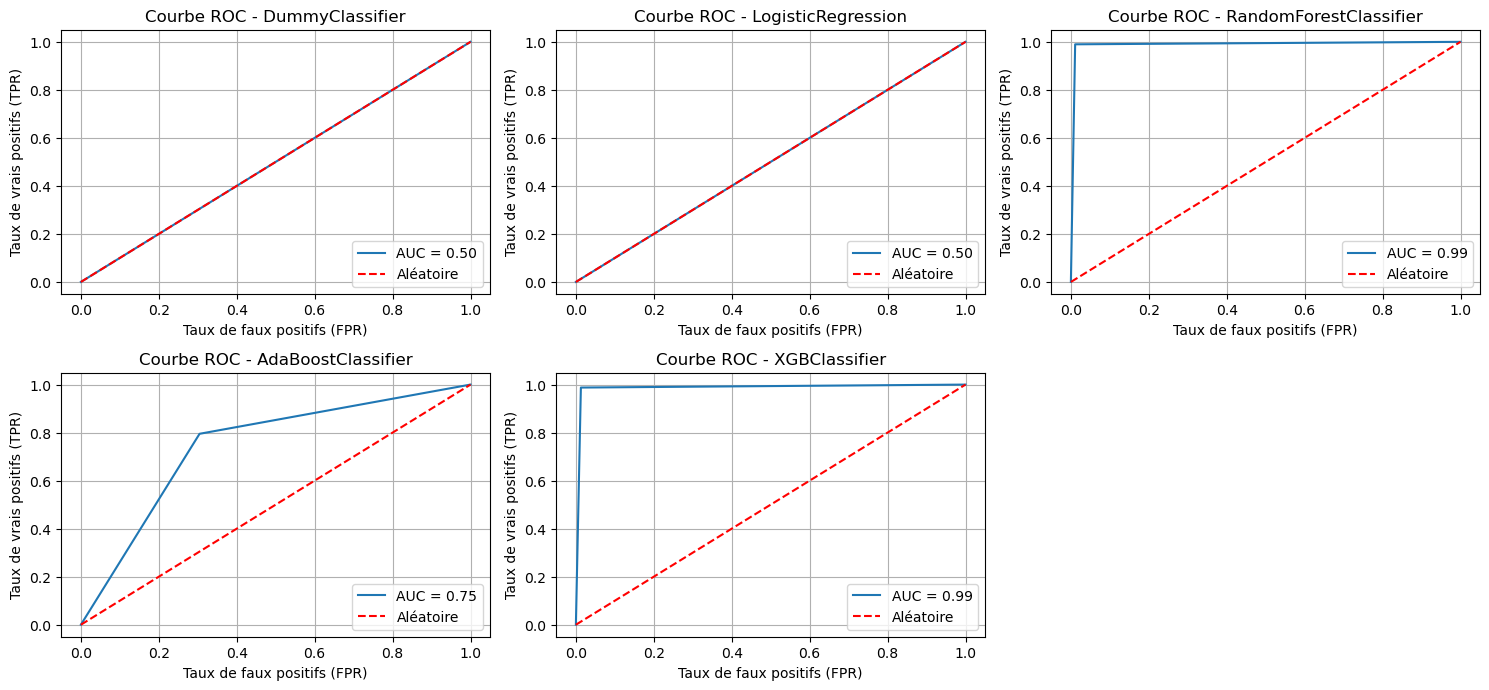

In [94]:
metric_plot(mesure)
graph_time(exe_time)
matrice(prediction,3,3)
ROC(model_entraine, X_test, y_test, 3,3)

### Récupération des meilleurs modèles :

In [96]:
Randomforest_path = r"RandomForestClassifier.pkl"
XGB_path= r"XGBClassifier.pkl"


In [97]:
Randomforest = read_data(Randomforest_path)
XGB = read_data(XGB_path)

Données chargées depuis RandomForestClassifier.pkl : RandomForestClassifier.pkl
Données chargées depuis XGBClassifier.pkl : XGBClassifier.pkl


# nouvelles données test : 

In [77]:
def preprocessed_data(new_df):
    """Fonction qui rétablit les mêmes acte de preprocessing qui a été effectué sur le train et à appliquer sur des données nouvelles """
    var_qual = list(encoder_feature.keys())
    var_cont = scaler.feature_names_in_.tolist()
    ident = [new_df["id"].name]
    new_df = new_df[ident+var_cont+var_qual]

    #imputation des NaN :

    nan_col_mode = imputer_mode.feature_names_in_.tolist() #récupération des colonnes ayant des NaN a imputer :
    new_df[nan_col_mode] = imputer_mode.transform(new_df[nan_col_mode])
    
    #pour cap-diameter
    new_df["cap-diameter"] = imputer_median.transform(new_df[["cap-diameter"]])

    #pour stem-height : 1 ligne avec NaN
    new_df["stem-height"] = new_df["stem-height"].fillna(new_df["stem-height"].mean()).isnull().sum()
    
    #Réduction du nombre de modalité 
    col_reduction_mode = [i for i in  new_df if i in var_qual and new_df[i].nunique()>4] #récupération des colonnes ayant trop de modalitées
    #Création d'un dictionnaire qui contiendra le nom des colonne et les modalités les moins présentent du jeu de données (<10%)
    dict_extra_modality = {}
    for i in col_reduction_mode:
        dict_extra_modality[i] = (new_df[i].value_counts(normalize=True))[new_df[i].value_counts(normalize=True)*100<10].index.tolist()
    #Réduction du nombre de modalité :

    for i in dict_extra_modality:
        new_df[i] = new_df[i].apply(lambda x:x if x not in dict_extra_modality[i] else "other")
    
    for column in var_qual: # Encodage des features restantes
        new_df[column] = encoder_feature[column].transform(new_df[column])
    return new_df


In [98]:
preprocessed_test_path = r"preprocessed_test.csv"
preprocessed_test = pd.read_csv(preprocessed_test_path,index_col=0)

In [99]:
print(preprocessed_test.shape)
preprocessed_test.head()

(2077964, 16)


,id,cap-diameter,stem-height,stem-width,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-color,has-ring,ring-type,habitat,season
0,3116945,8.64,0,17.12,4,2,0,2,0,0,3,2,2,1,0,0
1,3116946,6.90,0,10.75,2,2,1,0,0,0,4,0,0,0,0,0
2,3116947,2.00,0,3.14,0,0,0,0,0,0,0,0,0,0,0,1
3,3116948,3.47,0,8.51,4,2,0,0,2,0,0,2,2,1,0,2
4,3116949,6.17,0,13.70,4,0,3,0,2,0,4,3,2,0,0,2


In [100]:
def new_prediction(model, data):
    #Récupération des mêmes features que celles utilisés pour l'entrainement des modèles
    columns = model.feature_names_in_
    #Récupération de l'id du jeu de données
    id_data = data["id"]
    #Préparation du dataframe à tester :
    X = data[columns]
    #Récupération des prédictions
    numeric_prediction = model.predict(X)
    
    #Conversion des prédiction en données d'origine (textuelles et non numérique)
    class_predicted = encoder_label.inverse_transform(numeric_prediction)   
    #Transformation des prédictions en dataframe avec l'id en index
    prediction_df = pd.DataFrame(class_predicted, columns = ["class"], index = id_data)
#     prediction_df = pd.DataFrame(class_predicted, columns = ["class"], index = id_data)
    return prediction_df


In [101]:
RandomForestClassifier_df = new_prediction(model=Randomforest,data= preprocessed_test)
XGBClassifier_df = new_prediction(model=XGB,data= preprocessed_test)


In [102]:
RandomForestClassifier_df.to_csv("RandomForestClassifier_df_prediction.csv")

XGBClassifier_df.to_csv("XGBClassifier_prediction.csv")
